# Import Data 

To help us make useful predictions, we make use of data such as banners, events, and story releases. All data is split by JP / EN.

## Revenue Data

Please refer to the excel for more information.

In [45]:
import pandas as pd
reddit_data = pd.read_excel('./data/reddit-monthly-revenue-report.xlsx').iloc[:, :3]
ennead_data = pd.read_excel('./data/revenue-ennead-cc-revenue-report.xlsx')
revenue = pd.concat([reddit_data, ennead_data], ignore_index=True)
revenue

,Date,JP,Global
0,2021-02-01,NaN,NaN
1,2021-03-01,NaN,NaN
2,2021-04-01,NaN,NaN
3,2021-05-01,NaN,NaN
4,2021-06-01,NaN,NaN
5,2021-07-01,NaN,NaN
6,2021-08-01,NaN,NaN
7,2021-09-01,NaN,NaN
8,2021-10-01,NaN,NaN
9,2021-11-01,3000000.0,NaN


In [20]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    54 non-null     datetime64[ns]
 1   JP      45 non-null     float64       
 2   Global  44 non-null     float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.4 KB


## Banner Data

The info was sourced from here:
https://api.ennead.cc/buruaka/banner

In [7]:
import requests

banner_en = requests.get('https://api.ennead.cc/buruaka/banner').json()
all_banners_en = banner_en['ended'] + banner_en['current'] + banner_en['upcoming']
all_banners_en = pd.DataFrame(all_banners_en)

all_banners_en['startAt'] = pd.to_datetime(all_banners_en['startAt'], unit='ms')
all_banners_en['endAt'] = pd.to_datetime(all_banners_en['endAt'], unit='ms')
all_banners_en = all_banners_en.sort_values(by='startAt')
# all_banners_en

In [46]:
banner_jp = requests.get('https://api.ennead.cc/buruaka/banner?region=japan').json()
all_banners_jp = banner_jp['ended'] + banner_jp['current'] + banner_jp['upcoming']
all_banners_jp = pd.DataFrame(all_banners_jp)

all_banners_jp['startAt'] = pd.to_datetime(all_banners_jp['startAt'], unit='ms')
all_banners_jp['endAt'] = pd.to_datetime(all_banners_jp['endAt'], unit='ms')
all_banners_jp = all_banners_jp.sort_values(by='startAt')
all_banners_jp

,gachaType,startAt,endAt,rateups
1,PickupGacha,2021-02-04 08:00:00,2021-02-11 05:59:59,"[シロコ, ホシノ]"
2,PickupGacha,2021-02-11 07:00:00,2021-02-25 06:01:00,[マシロ]
3,PickupGacha,2021-02-25 06:30:00,2021-03-11 04:00:00,"[イズナ, シズコ]"
0,PickupGacha,2021-03-07 04:30:00,2021-04-29 04:00:00,[チェリノ]
4,PickupGacha,2021-03-11 04:30:00,2021-03-18 04:00:00,[ハルナ]
...,...,...,...,...
384,PickupGacha,2025-08-13 03:00:00,2025-08-20 02:59:59,[カンナ]
382,LimitedGacha,2025-08-13 03:00:00,2025-08-20 02:59:59,[トキ]
385,PickupGacha,2025-08-13 03:00:00,2025-08-20 02:59:59,[チアキ]
386,PickupGacha,2025-08-20 03:00:00,2025-09-03 02:59:59,[エリ]


## Story Release

The info was sourced from here:
https://bluearchive.fandom.com/wiki/Story/Main_Story

Unfortunately, only the JP dates are available.

In [9]:
story_jp = pd.read_excel('./data/story-jp.xlsx').iloc[:, :5]
story_jp.head()
# story_jp.info()

,Volume,Full Name,Chapter,Part,Release Date
0,1,The Foreclosure Task Force,1,NaN,2021-02-04 00:00:00
1,1,The Foreclosure Task Force,2,1.0,2021-03-11 00:00:00
2,1,The Foreclosure Task Force,2,2.0,2021-03-18 00:00:00
3,1,The Foreclosure Task Force,3,0.0,2024-02-07 00:00:00
4,1,The Foreclosure Task Force,3,1.0,2024-04-11 00:00:00


## Event Schedule

The data was sourced from here: https://bluearchive.wiki/wiki/Events

In [10]:
event_en = pd.read_excel('./data/event-en.xlsx')
event_jp = pd.read_excel('./data/event-jp.xlsx').iloc[:, :5]
# event_en
event_jp

,Name (EN),Name (JP),Start date,End date,Notes
0,Cherry Blossom Festival Commotion! ~Flowers in...,桜花爛漫お祭り騒ぎ！~空に徒花 地に忍び~,2021-02-25,2021-03-11,NaN
1,"Revolutionary Ivan Kupala: Moustache, Pudding ...",革命のイワン・クパーラ 髭とプリンとレッドウィンター,2021-04-29,2021-05-13,NaN
2,Summer Sky's Wishlist,夏空のウィッシュリスト,2021-06-30,2021-07-15,NaN
3,～Emergency Special Order of the Disciplinary c...,～風紀委員会行政官緊急特務命令～ ヒナ委員長のなつやすみっ！,2021-07-29,2021-08-12,NaN
4,Catch in Neverland,ネバーランドでつかまえて,2021-08-26,2021-09-09,NaN
...,...,...,...,...,...
79,A Flower Blooms Among The Hundred ～ Honorable ...,百ヨリ出ズル一輪ノ～いざ尋常に、水上勝負～,2025-06-25,2025-07-09,NaN
80,Summer Sky's Promise,夏空のやくそく,2025-07-22,2025-08-06,NaN
81,Say-Bing!,Say-Bing!,2025-08-06,2025-08-13,NaN
82,We are the Occult Research Society! ～Academy M...,我らオカルト研究会！～学院の不思議と古の呪文～,2025-08-20,2025-09-03,NaN


# EDA

In [49]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

def millions_formatter(x, pos):
    '''
    Format the y-axis ticks to show millions.
    '''
    return f'{x * 1e-6:.1f}M'

def plot_revenue_monthly(df: pd.DataFrame, region: str = 'JP'):
    '''
    Plot the monthly revenue time series with one subplot per year.
    df: revenue DataFrame
    region: string, the region to plot (default is 'JP')
    '''
    # Ensure 'Date' is datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Sort by date
    df = df.sort_values(by='Date')
    
    # Extract unique years
    years = df['Date'].dt.year.unique()
    
    # Create subplots: one row per year
    fig, axes = plt.subplots(len(years), 1, figsize=(12, 4*len(years)), sharey=True)
    
    for ax, year in zip(axes, years):
        subset = df[df['Date'].dt.year == year]
        sns.lineplot(data=subset, x='Date', y=region, ax=ax)
        
        # Format y-axis in millions
        ax.yaxis.set_major_formatter(millions_formatter)
        
        # X-axis: one tick per month
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

        # Rotate x-axis labels
        ax.tick_params(axis='x', rotation=45)
        
        # Set title
        ax.set_title(f'Revenue for {region} ({year})')

    # Adjust layout
    plt.tight_layout()
    plt.show()

def plot_revenue_yearly(df: pd.DataFrame, region: str = 'JP'):
    '''
    Plot the yearly revenue time series.
    df: revenue DataFrame
    region: string, the region to plot (default is 'JP')
    '''

    # Ensure 'Date' is datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Sort by date
    df = df.sort_values(by='Date')

    # Adjust Size
    plt.figure(figsize=(12, 6))
    
    ax = sns.lineplot(data=df, x='Date', y=region)

    # Format y-axis in millions
    ax.yaxis.set_major_formatter(millions_formatter)
    
    # X-axis: one tick per month
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Set title
    ax.set_title(f'Revenue for {region}')

    # Adjust layout
    plt.tight_layout()
    plt.show()

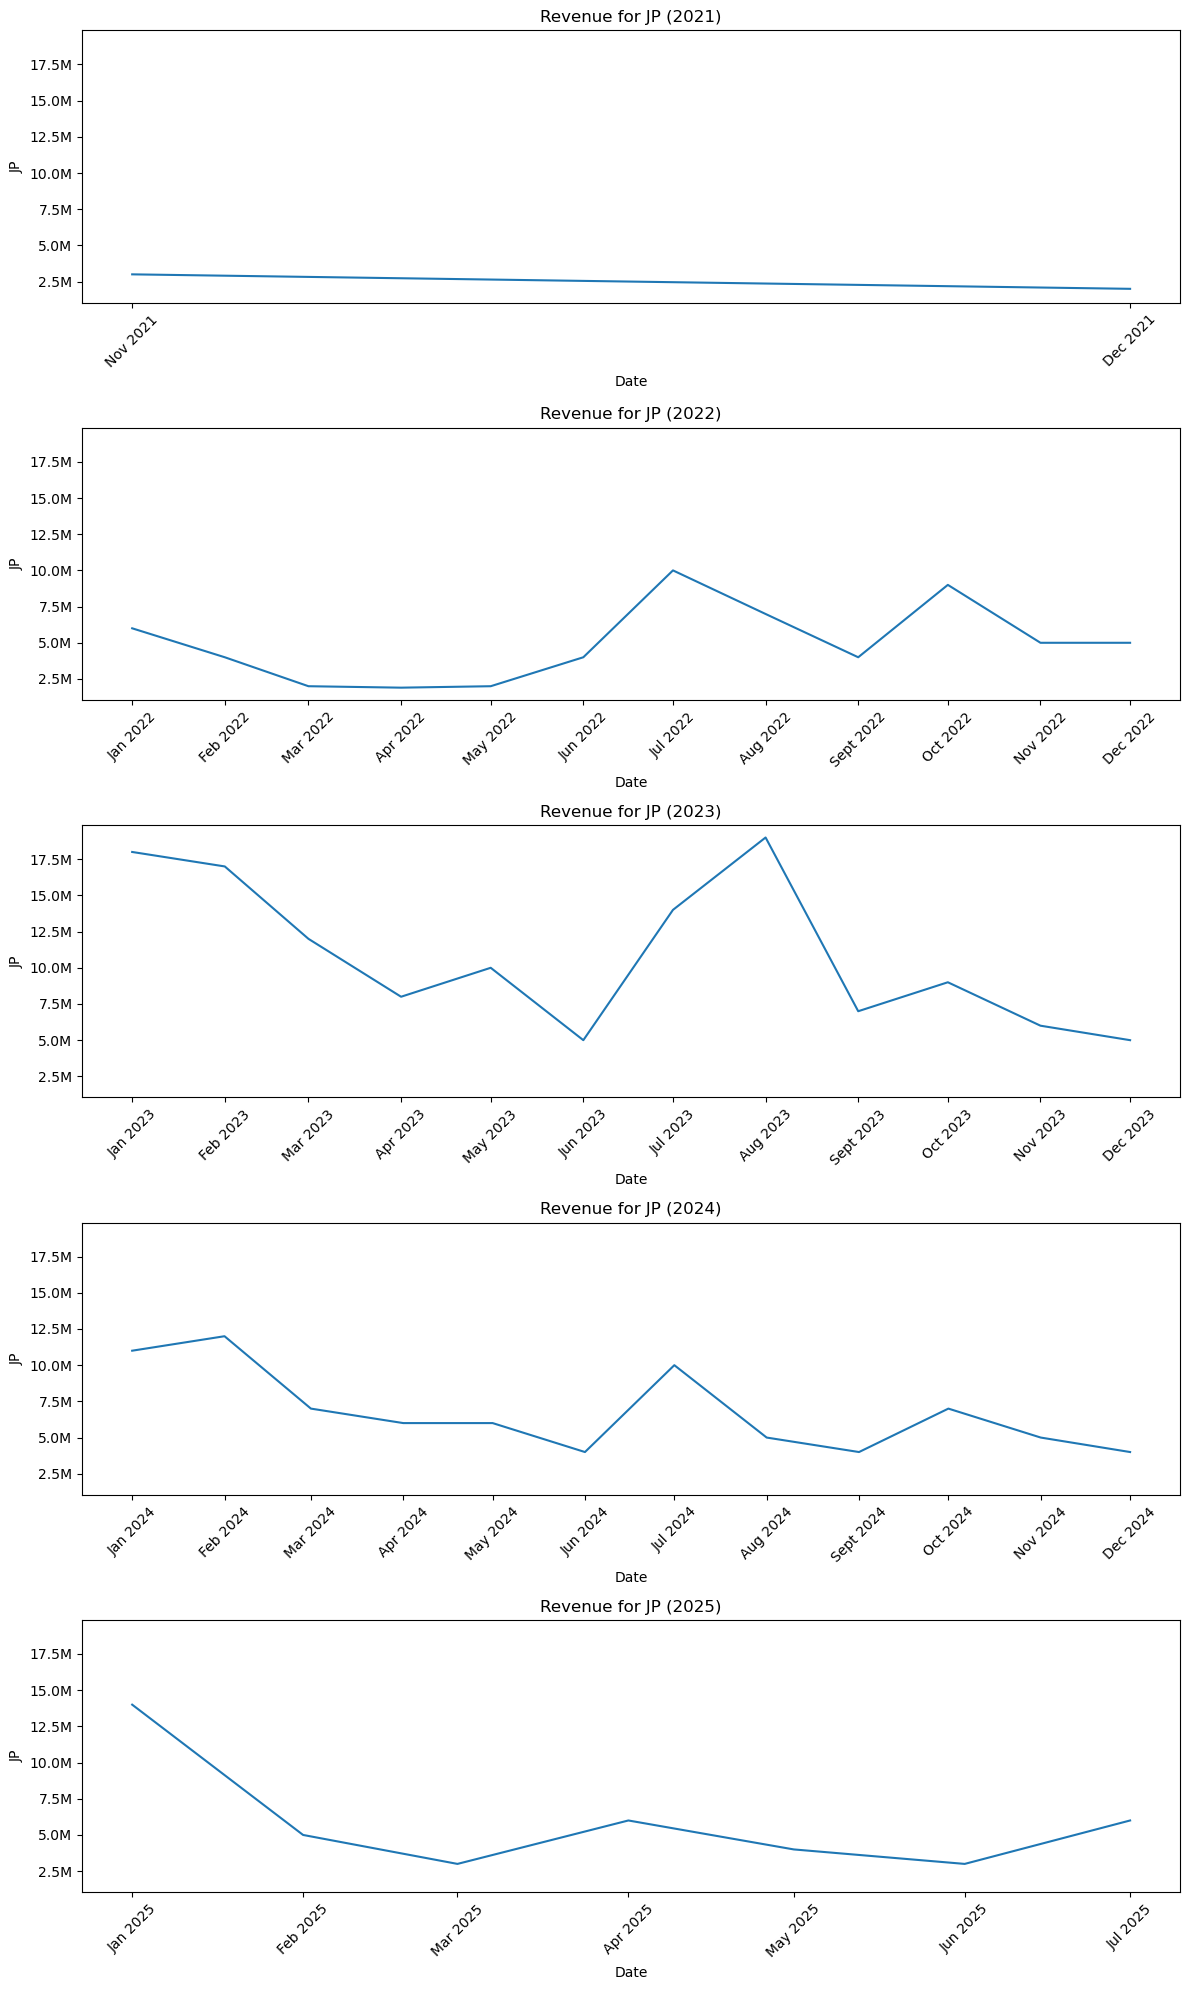

In [50]:
plot_revenue_monthly(revenue)

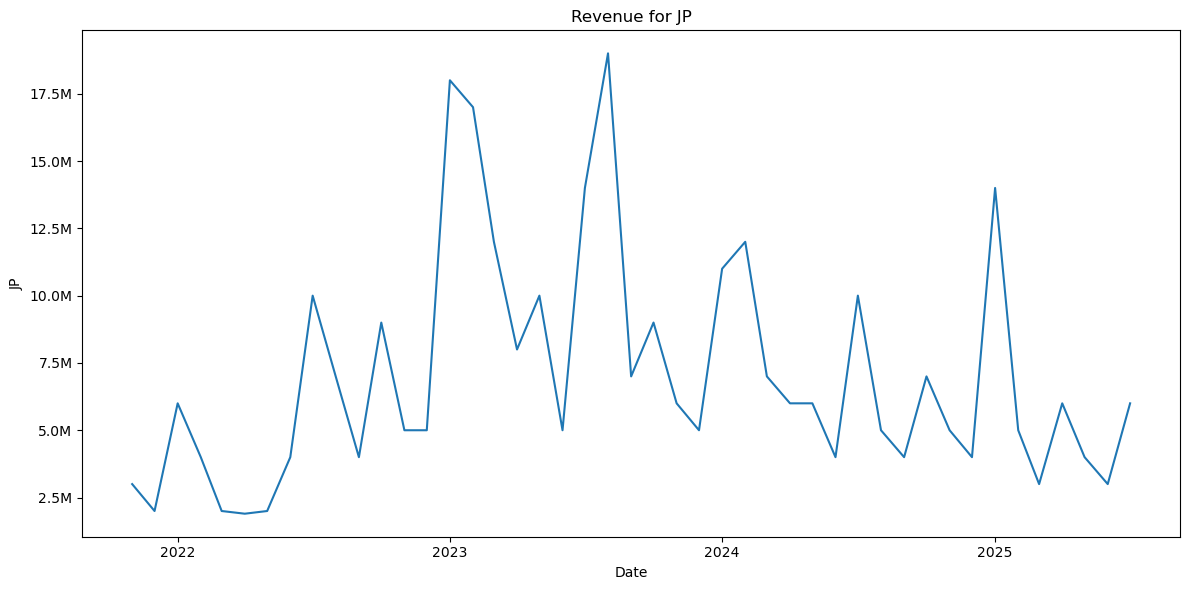

In [51]:
plot_revenue_yearly(revenue)